In [1]:
import os
from classes.GAN import GAN
#from utils.callbacks import WandbImagesGAN

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose,ToTensor,Resize,PILToTensor
from torchvision.io import read_image
from torchsummary import summary


from torch import distributions as D
import wandb

from imutils import paths
import matplotlib.pyplot as plt
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante (use `wandb login --relogin` to force relogin)


True

In [2]:
discriminator_architecture=[[1,32],[1,64],[0,128]]
generator_architecture=[[1,64],[1,128]]

latent_dim=24
input_dim=(3,128,128)


INIT_LR=1e-4
EPOCHS=10

BS=128

config={"dataset":"MNIST", "type":"GAN","generator_architecture":generator_architecture,"discriminator_architecture":discriminator_architecture}

config["latent_dim"]=latent_dim
config["input_dim"]=input_dim


In [3]:
model=GAN(latent_dim=latent_dim,target_shape=(1,28,28),discriminator_architecture=discriminator_architecture,generator_architecture=generator_architecture)

C:\Users\matte\anaconda3\envs\ai_pytorch\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
summary(model.generator,(latent_dim,),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3136]          78,400
   ConvTranspose2d-2             [-1, 64, 7, 7]          36,928
             PReLU-3             [-1, 64, 7, 7]               1
          Upsample-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          36,928
       BatchNorm2d-6           [-1, 64, 14, 14]             128
            Conv2d-7           [-1, 64, 14, 14]          36,928
       BatchNorm2d-8           [-1, 64, 14, 14]             128
              ReLU-9           [-1, 64, 14, 14]               0
           Conv2d-10           [-1, 64, 14, 14]          36,928
      BatchNorm2d-11           [-1, 64, 14, 14]             128
        LeakyReLU-12           [-1, 64, 14, 14]               0
    ResidualBlock-13           [-1, 64, 14, 14]               0
ConvTransposeResBlock-14           [-1,

In [5]:
summary(model.discriminator,(1,28,28),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
            Conv2d-2           [-1, 32, 14, 14]           9,248
       BatchNorm2d-3           [-1, 32, 14, 14]              64
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         LeakyReLU-9           [-1, 32, 14, 14]               0
    ResidualBlock-10           [-1, 32, 14, 14]               0
     ConvResBlock-11           [-1, 32, 14, 14]               0
           Conv2d-12             [-1, 64, 7, 7]          18,496
           Conv2d-13             [-1, 64, 7, 7]          36,928
      BatchNorm2d-14             [-1, 6

In [6]:
transform=Compose([ToTensor()])

train_dataset=MNIST('mnist_train', train=True, download=True,
                             transform=transform)
test_dataset=MNIST('mnist_test', train=False, download=True,
                             transform=transform)



C:\Users\matte\anaconda3\envs\ai_pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
train_dataloader=DataLoader(train_dataset,batch_size=BS,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=BS,shuffle=True)


In [8]:
base_path="models/gan_mnist"
os.makedirs(base_path,exist_ok=True)

In [9]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [10]:
wandb.init(project="NeuroGEN_Pytorch",config=config)

wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [11]:
x,y=next(iter(train_dataloader))

In [12]:
model.to(device)

z = torch.randn(x.shape[0], latent_dim).to(device)

print(z.shape)
x_gen=model.generator(z)
print(x_gen.shape)

torch.Size([128, 24])
torch.Size([128, 1, 28, 28])


In [13]:
valid = torch.ones(x.size(0), 1)
valid = valid.to(device)

y_pred=model.discriminator(x_gen)
print(y_pred.shape,valid.shape)


torch.Size([128, 1]) torch.Size([128, 1])


In [14]:
y_pred.get_device(),valid.get_device()

(0, 0)

In [15]:
g_loss=model.adversarial_loss(y_pred,valid)
g_loss

tensor(0.8622, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

Epoch 0: 100%|████████████████████████████████████████████████████████████████████| 469/469 [00:59<00:00,  7.85batch/s]


(100, 28, 28, 1) (100, 28, 28, 1)


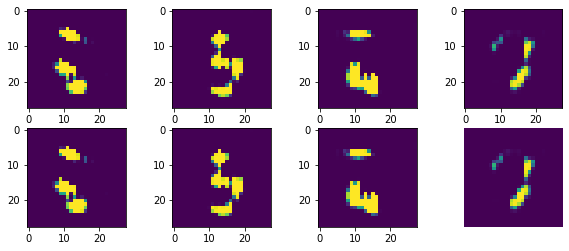

Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 469/469 [01:00<00:00,  7.80batch/s]


(100, 28, 28, 1) (100, 28, 28, 1)


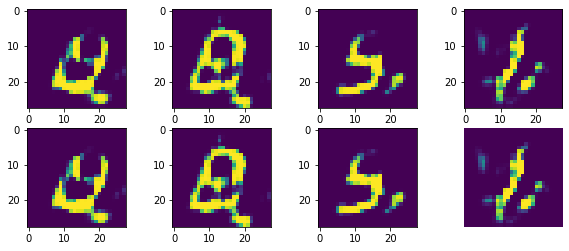

Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 469/469 [01:01<00:00,  7.66batch/s]


(100, 28, 28, 1) (100, 28, 28, 1)


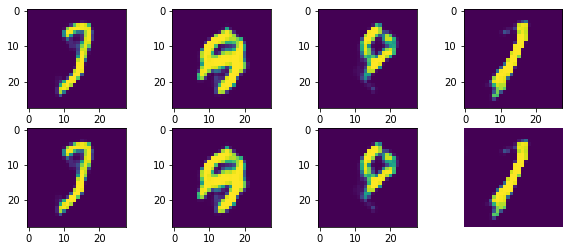

Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 469/469 [01:02<00:00,  7.45batch/s]


(100, 28, 28, 1) (100, 28, 28, 1)


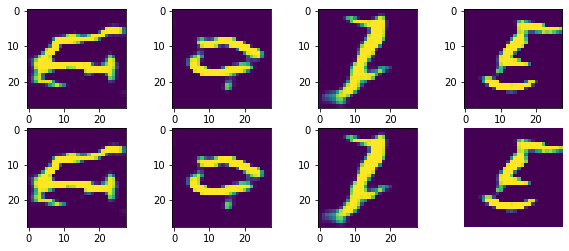

Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 469/469 [01:03<00:00,  7.37batch/s]


(100, 28, 28, 1) (100, 28, 28, 1)


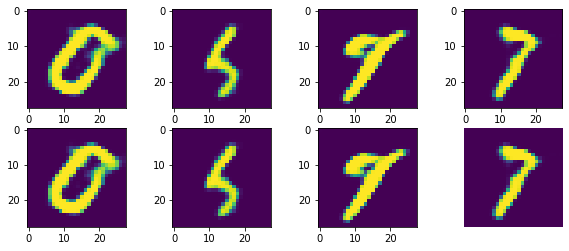

Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 469/469 [01:03<00:00,  7.35batch/s]


(100, 28, 28, 1) (100, 28, 28, 1)


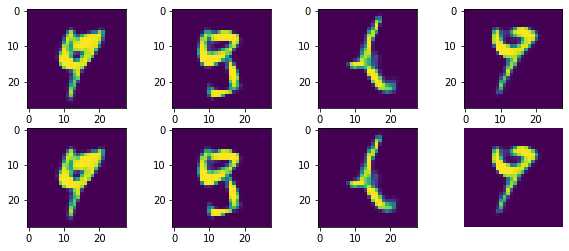

Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.32batch/s]


(100, 28, 28, 1) (100, 28, 28, 1)


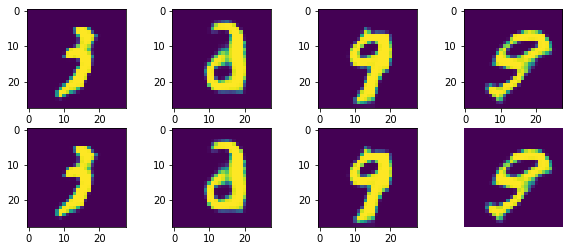

Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 469/469 [01:04<00:00,  7.24batch/s]


(100, 28, 28, 1) (100, 28, 28, 1)


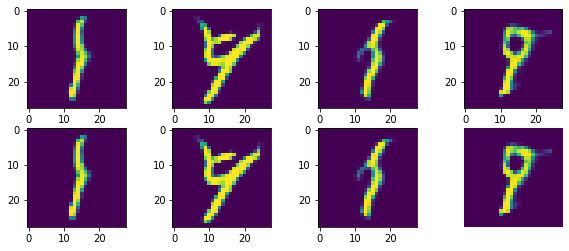

Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 469/469 [01:06<00:00,  7.10batch/s]


(100, 28, 28, 1) (100, 28, 28, 1)


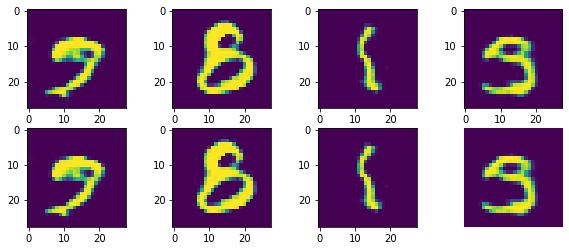

Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 469/469 [01:06<00:00,  7.06batch/s]


(100, 28, 28, 1) (100, 28, 28, 1)


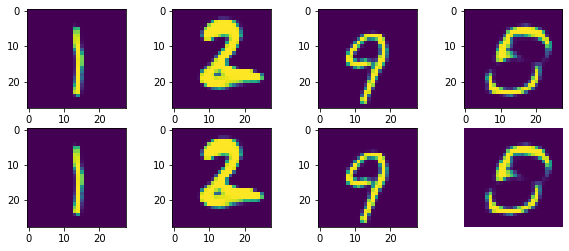

wandb: Network error resolved after 0:00:34.865604, resuming normal operation.


In [16]:

g_optimizer=torch.optim.Adam(model.generator.parameters(),lr=INIT_LR)
d_optimizer=torch.optim.Adam(model.discriminator.parameters(),lr=INIT_LR)

model.to(device)

model.fit(train_dataloader=train_dataloader,epochs=EPOCHS,g_optimizer=g_optimizer,d_optimizer=d_optimizer,device=device,wandb_log=True,save_model=base_path,early_stop=3)